In [139]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()

In [140]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [141]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test, valid = torch.utils.data.random_split(testset,[9000,1000])

test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [142]:
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda

The model will be running on cuda:0 device


In [143]:
from torch.autograd import Variable
from tqdm import tqdm

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
loss_values = []
validation_loss_values = []
def train(num_epochs):
    best_accuracy = 0.0
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(tqdm(train_loader, 0)):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
        loss_values.append(running_loss / len(train_loader))
        
        # validation losses
        model.eval()
        valid_loss = 0
        for i, (images, labels) in enumerate(tqdm(valid_loader, 0)):
            # get the input
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            # predict classes using images from the training set
            outputs = model(images)

            # compute the loss based on model output and real labels
            running_valid_loss = loss_fn(outputs, labels)

            # Let's print statistics for every 1,000 images
            valid_loss += running_valid_loss.item()   # extract the loss value
        validation_loss_values.append(valid_loss / len(valid_loader))

        # print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [144]:
train(num_epochs=6)

100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 149.82it/s]


For epoch 1 the test accuracy over the whole test set is 59 %


100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 166.18it/s]


For epoch 2 the test accuracy over the whole test set is 66 %


100%|██████████████████████████████████████████████████████████████| 563/563 [00:02<00:00, 198.10it/s]


For epoch 3 the test accuracy over the whole test set is 67 %


100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 157.47it/s]


For epoch 4 the test accuracy over the whole test set is 68 %


100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 175.74it/s]


For epoch 5 the test accuracy over the whole test set is 70 %


100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 155.51it/s]

For epoch 6 the test accuracy over the whole test set is 70 %


In [145]:
testAccuracy()

100%|██████████████████████████████████████████████████████████████| 563/563 [00:03<00:00, 150.88it/s]


70.77777777777777

In [146]:
loss_values

[1.3605176231956482,
 1.0344088268899918,
 0.9013865789580345,
 0.8203176750516892,
 0.7592182587051391,
 0.7081134092736244]

In [147]:
validation_loss_values

[1.1754199067751567,
 0.9687516358163621,
 0.9449403631308723,
 0.9436749347618648,
 0.8589039577378167,
 0.8421527908907996]

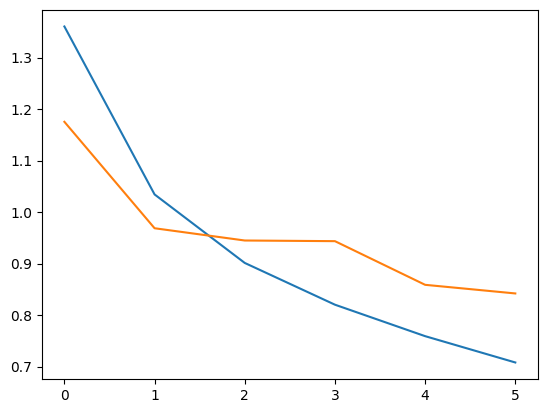

In [149]:
# loss graph
import matplotlib.pyplot as plt
plt.plot(loss_values, label="training loss")
plt.plot(validation_loss_values, label="validation loss")